# Lab 2: Manipulator dynamics simulation

<div style="color: red;">

Pendientes lab2:
    
1. Graficar en Python
2. Explicar las gráficas
3. Pendiente unidades de las variables q, q' y q''
</div>

## Questions

### Question 2.1: Graphical representation

- What are the effects of modifying the dynamics parameters of the arm?

You can modify some of the following parameters inside the dynamics_params.yaml: m1, m2, b1, b2, and g. Run different experiments and plot the data to see the effects of those parameters.

Note that you only need to modify those inside uma_arm_dynamics.

### Answer 2.1

We have performed 8 experiments: the base one with the default parameters and the other 7 duplicating one of the parameters

When running in ROS, it is difficult to compare the results due to the non reproductibility of the results:(the same experiment may produce different results depending on the processes that are running on the computer while the experiment is running)

This problem can be overcome by using Simulink instead of ROS, since the results of the experiment doesn't depend on race conditions, so we have replicated the model in Simulink:

![Lab2 Simulink](lab2simulink.jpg)

The code in this system is equivalent to the one running in C++:

```C
function qddot = dinamics_model(par, torques, wrenches, q, qdot)

    m1 = par(1);
    m2 = par(2);
    l1 = par(3);
    l2 = par(4);
    b1 = par(5);
    b2 = par(6);
    g = par(7);

    % sines and cosines
    sq1 = sin(q(1));
    sq2 = sin(q(2));
    cq1 = cos(q(1));
    cq2 = cos(q(2));
    sq12 = sin(q(1)+q(2));
    cq12 = cos(q(1)+q(2));
    
    % Calculate M(1)
    Msim = m2*(l1*l2*cq2 + l2^2); % simetrical term
    M = [m1*l1^2+m2*(l1^2+2*l1*l2*cq2+l2^2), Msim;
         Msim, m2*l2^2];
         
    % Calculate C(q, qdot)*qdot
    Cqdot = [-m2*l1*l2*sq2*(2*qdot(1)*qdot(2)+qdot(2)^2);
              m2*l1*l2*qdot(1)^2*sq2];

    % Calculate Fb
    Fb = [b1, 0;
          0, b2];

    % Calculate g(q)
    g = [(m1+m2)*l1*g*cq1+m2*g*l2*cq12;
          m2*g*l2*cq12];

    % Calculate J(q)
    J = [-l1*sq1-l2*sq12, -l2*sq12;
          l1*cq1+l2*cq12,  l2*cq12];

    % Calcualte tau_ext
    tau_ext = J' * wrenches;
    
    % Calculate qddot
    qddot = inv(M)*(torques - Cqdot - Fb*qdot - g + tau_ext);
```

To execute the 8 experiments we have developed the following code:

- [runExperiment.m](../../matlab/lab2/runExperiment.m): Run one experiment and store the results in a csv file
- [lab2init.m](../../matlab/lab2/lab2init.m): Set the parameters for each experiment and invoke runExperiment

To Analyze the results in Python, we have created the following function which compartes two experiments plotting the 3 type of variables (q, q' and q'') for the two articulations (q1 and q2) and the two experiments (base and modification):


In [17]:
import pandas as pd
import matplotlib.pyplot as plt

dfBase = pd.read_csv("../../matlab/lab2/experiment1.csv")
x = dfBase.index
colnames = dfBase.columns
colorBase = ['green', 'blue']*3
colorCamb = ['olive', 'cyan']*3
tiposCamb = ['0 no aplica', 'base', 'm1*2', 'm2*2', 'l1*2', 'l2*2', 'b1*2', 'b2*2', 'g*2' ]
ejesy = ["q (rad)", r"$q' (rad/s)$", r"q'' $(rad/s^2)$"] 
tipoBase = ' '+tiposCamb[1]

def Comparar(iCamb): # iCamb = 2...8
    dfCamb = pd.read_csv("../../matlab/lab2/experiment{}.csv".format(iCamb))
    fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharey=False)
    tipoCamb = ' '+tiposCamb[iCamb]
    for i, ax in enumerate(axes):
        colx = colnames[i*2]
        coly = colnames[i*2+1]
        ax.plot(x, dfBase[colx], label=colx+tipoBase, color=colorBase[i*2], linestyle='-', linewidth=1, alpha=0.9)
        ax.plot(x, dfBase[coly], label=coly+tipoBase, color=colorBase[i*2+1], linestyle='-', linewidth=1, alpha=0.9)
        ax.plot(x, dfCamb[colx], label=colx+tipoCamb, color=colorCamb[i*2], linestyle='--', linewidth=2, alpha=0.9)
        ax.plot(x, dfCamb[coly], label=coly+tipoCamb, color=colorCamb[i*2+1], linestyle='--', linewidth=2, alpha=0.9)
        ax.grid(True) # Add a grid for easier reading
        ax.legend(loc='lower right') # Show the legend with labels
        ax.tick_params(axis='x', labelbottom=(i==2), bottom=(i==2))
        ax.set_ylabel(ejesy[i])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    fig.suptitle("Experimento 1 ({}) vs Experimento {} ({})".format(tiposCamb[1], iCamb, tiposCamb[iCamb]))
    plt.subplots_adjust(wspace=0, hspace=0)


#### Base

The results of the base experiment run in ROS are plotted in the next figure

**ros2 bag record --all -o lab2bag1 -s mcap # base => m1=3, m2=2, l1=1, l2=0.6, b1=5, b2=5, g=9.81**

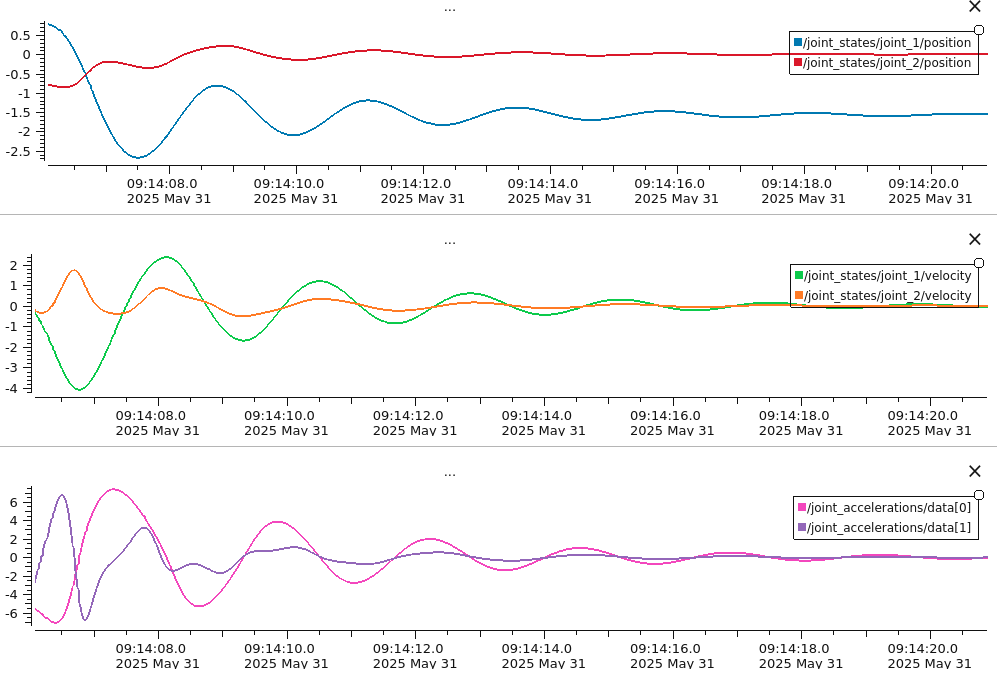

To plot the same using Python, we artificially compare experiment 1 to experiment 1, so that the results of the base (continuous line) and the change (dashed line) are superposed

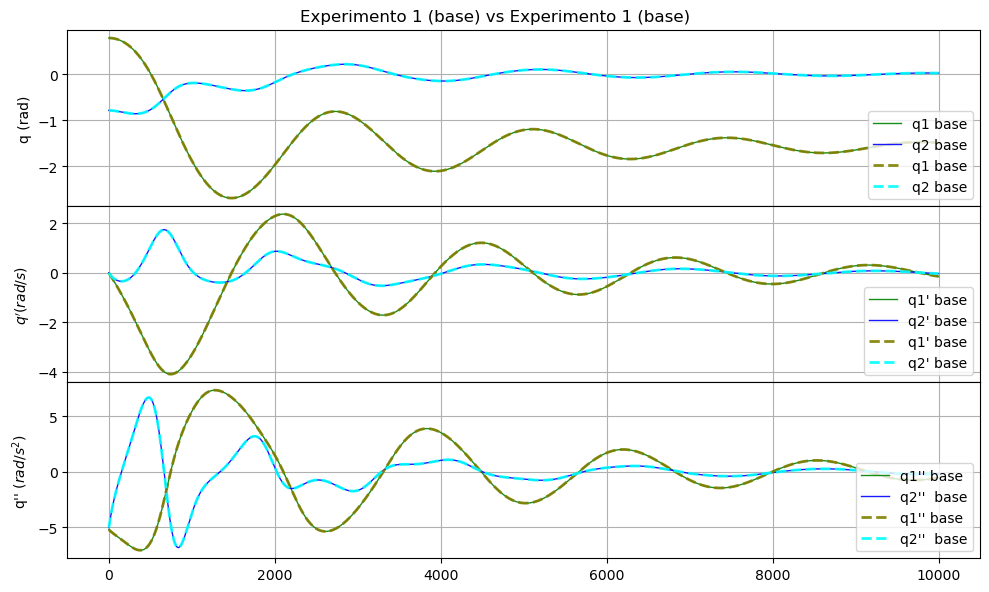

In [18]:
Comparar(1)

#### Duplicate the mass m1

The results of the experiment run in ROS are as follows:

**ros2 bag record --all -o lab2bag2 -s mcap # base salvo m1=6**

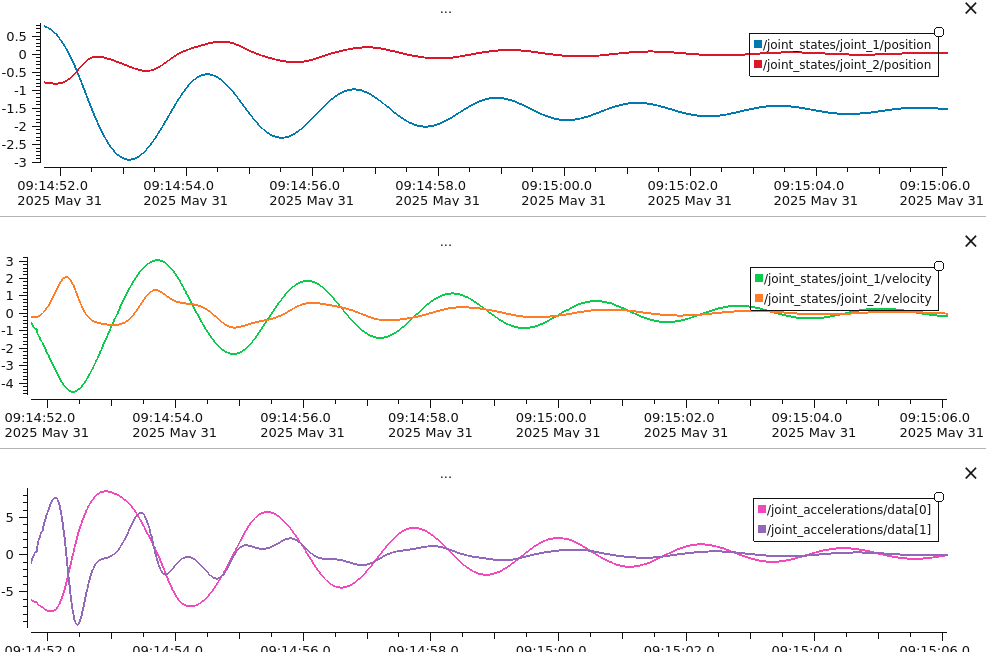

In the Python plot it is easier to see that the bigger impact is in the acceleration of q2 (dashed q2'' in cyan)

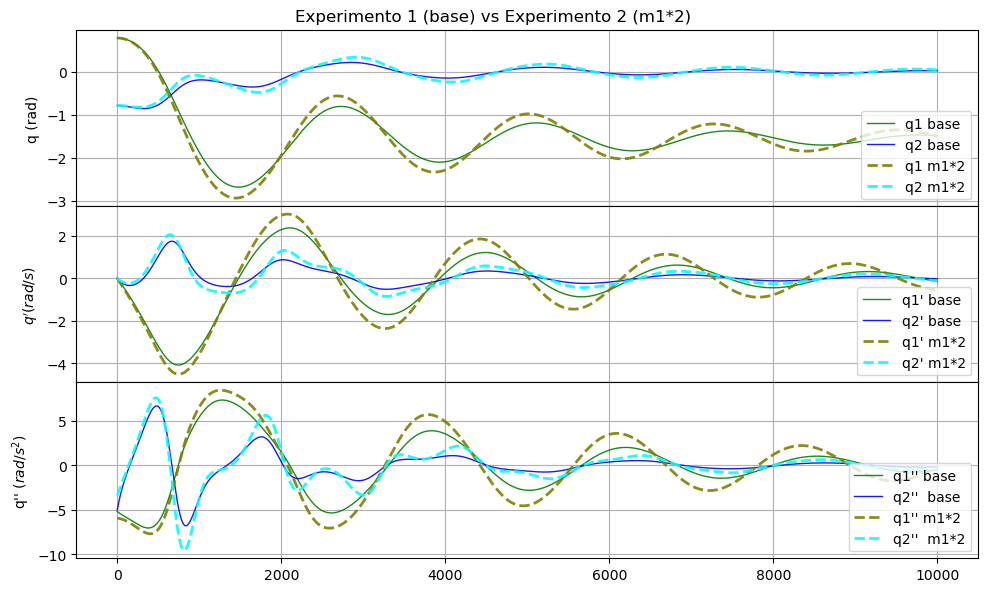

In [19]:
Comparar(2)

#### Duplicate mass m2

**ros2 bag record --all -o lab2bag3 -s mcap # base salvo m2=4**

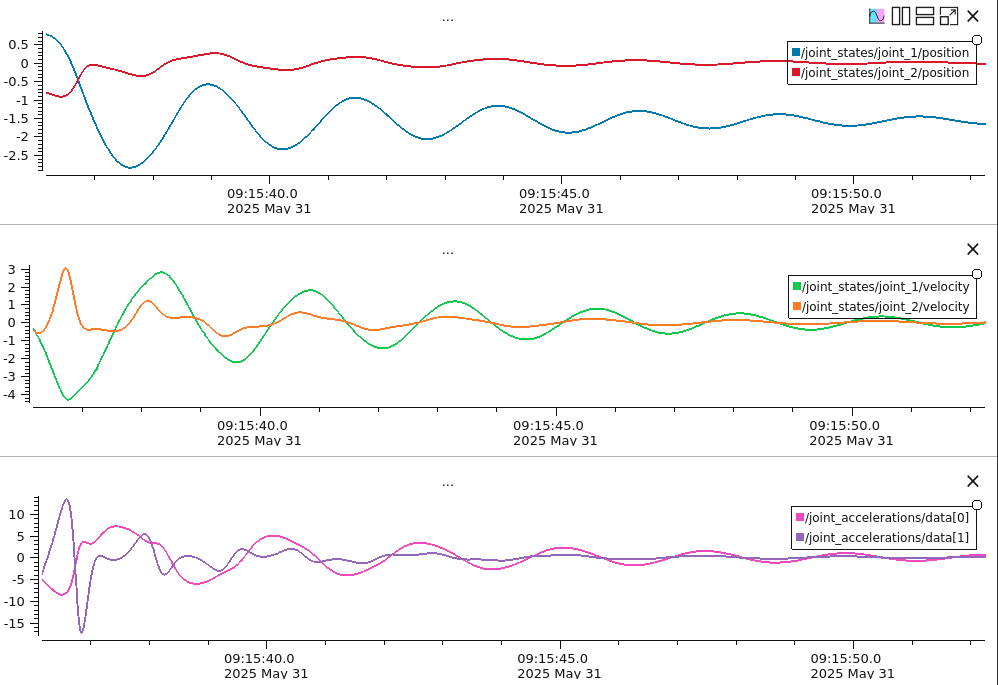



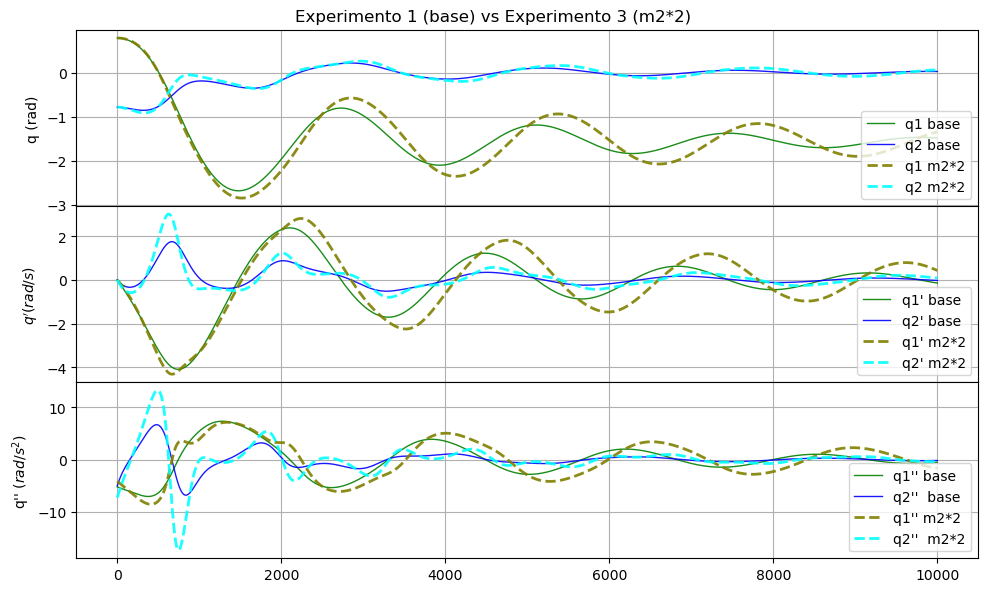

In [20]:
Comparar(3)

#### Duplicate length L1

**ros2 bag record --all -o lab2bag4 -s mcap # base salvo L1=2**

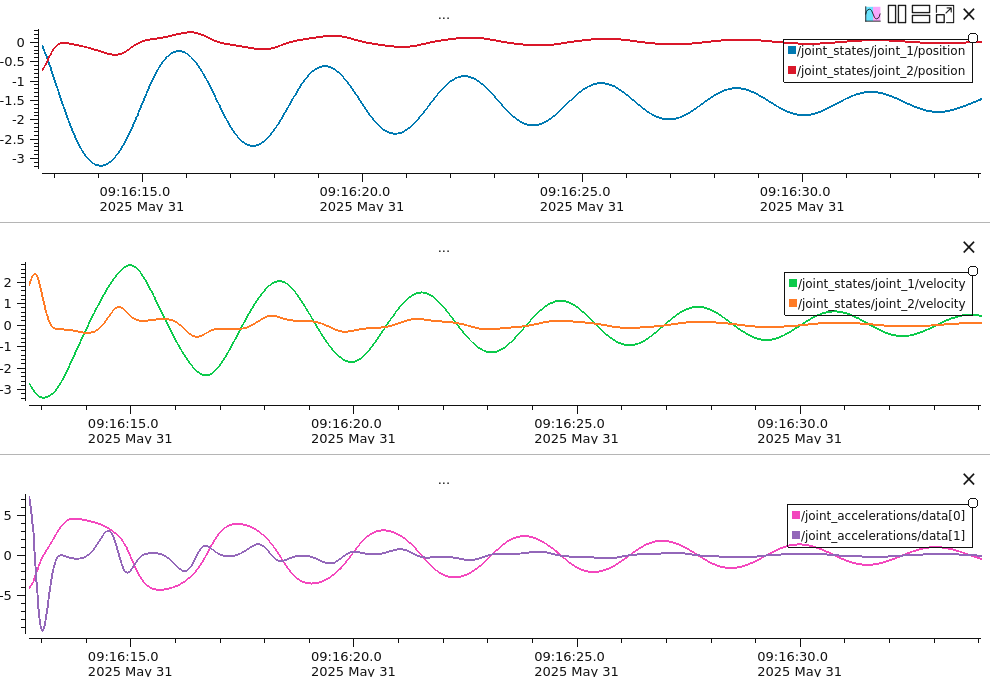

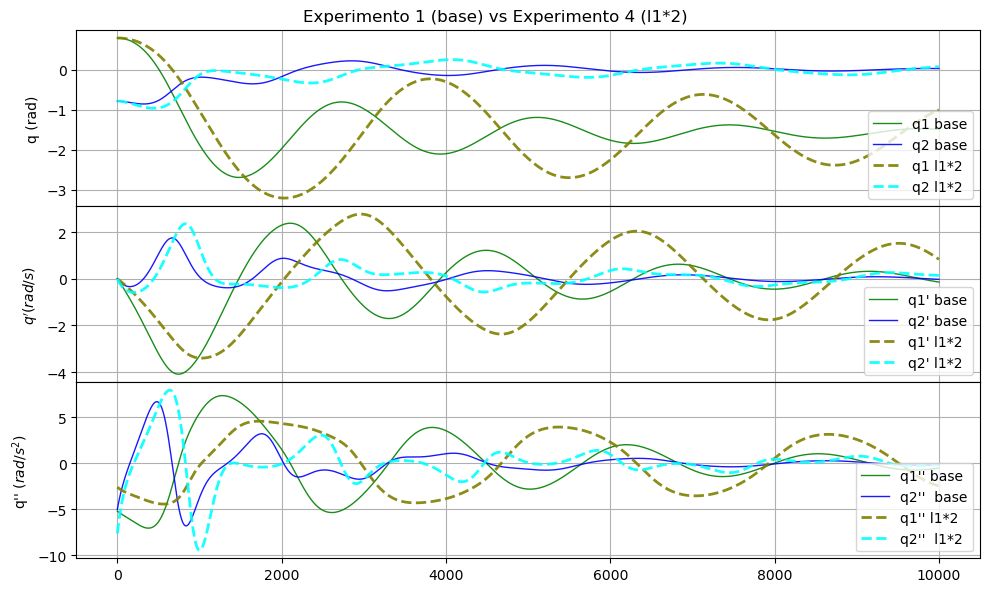

In [21]:
Comparar(4)

#### Duplicate length L2

**ros2 bag record --all -o lab2bag5 -s mcap # base salvo L2=1.2**

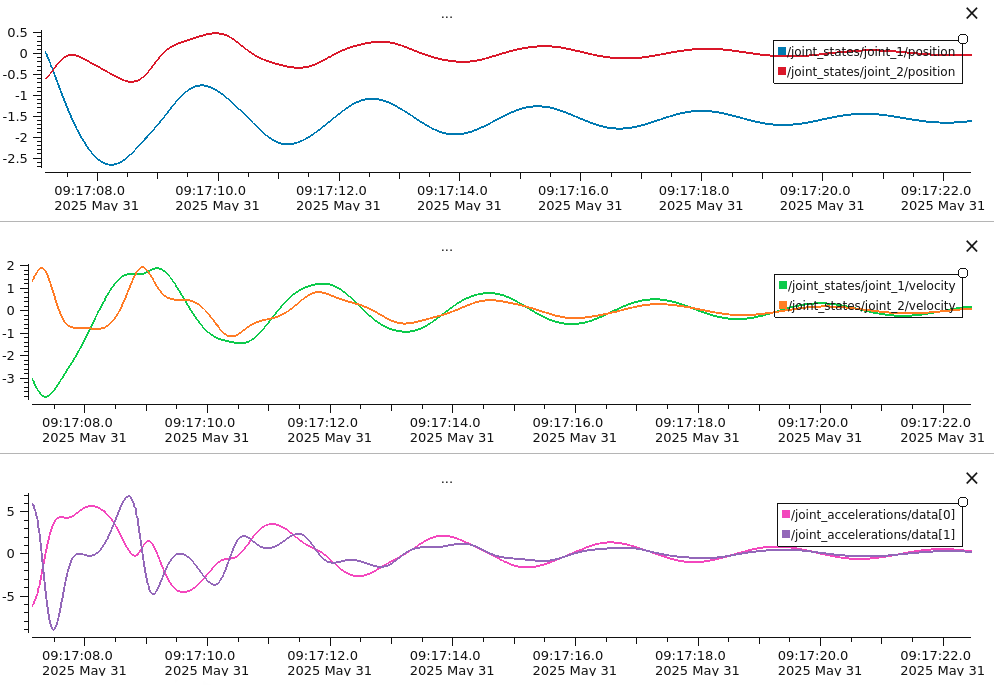


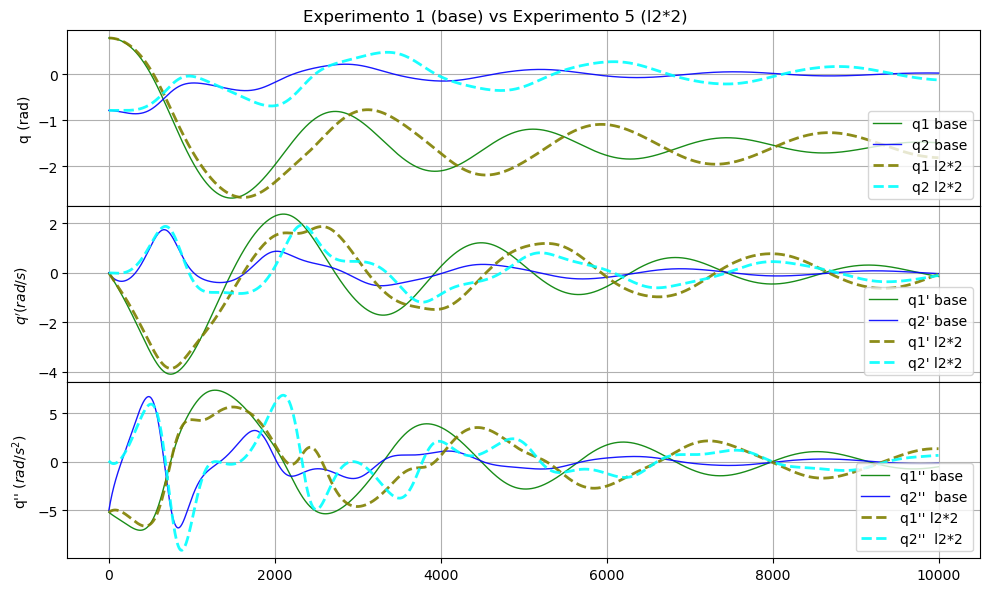

In [22]:
Comparar(5)

#### Duplicate viscous friction b1

**ros2 bag record --all -o lab2bag6 -s mcap # lab26bag: base salvo b1=10**

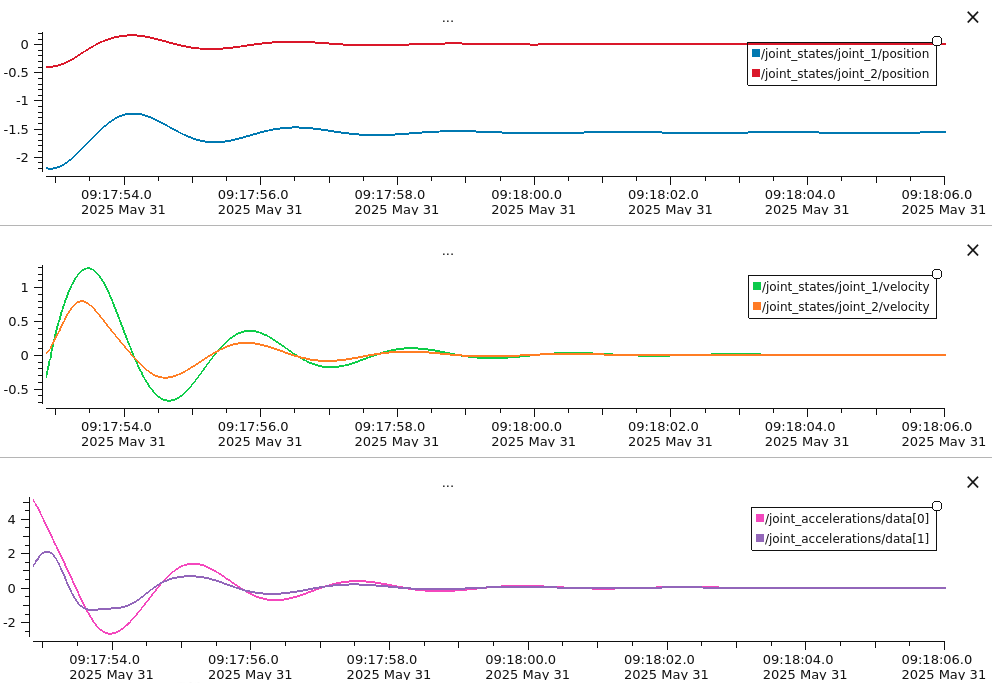


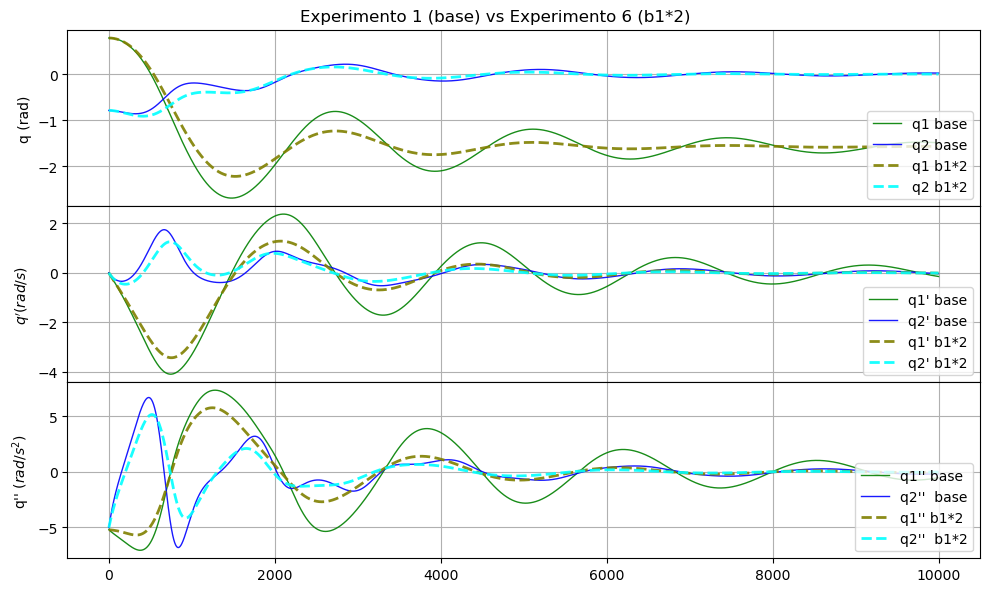

In [23]:
Comparar(6)

#### Duplicate viscous friction b2

**ros2 bag record --all -o lab2bag7 -s mcap # lab27bag: base salvo b2=10**

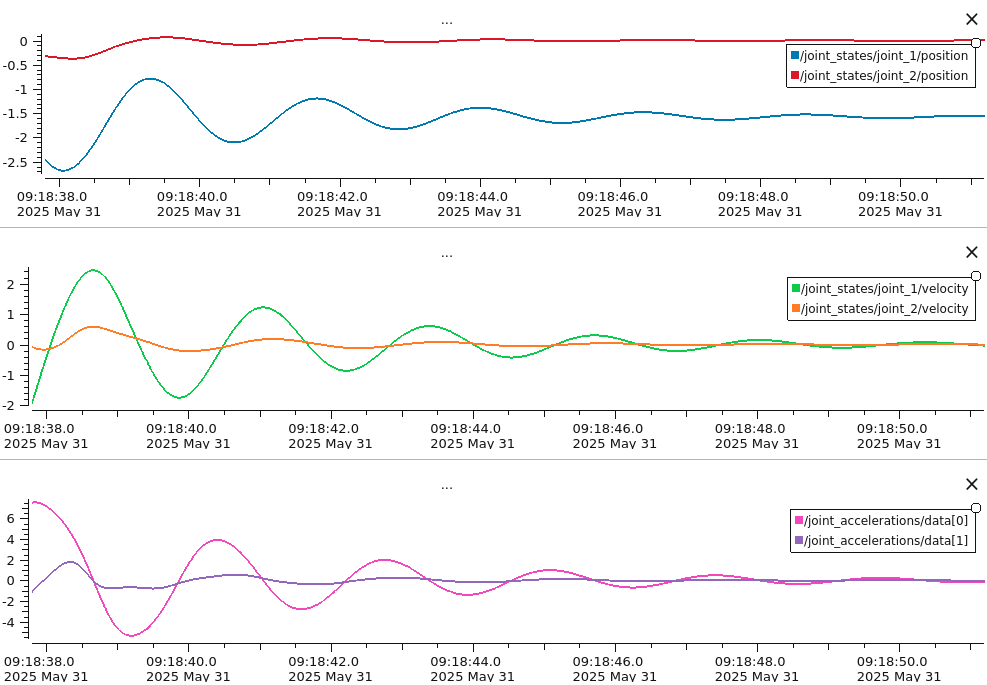

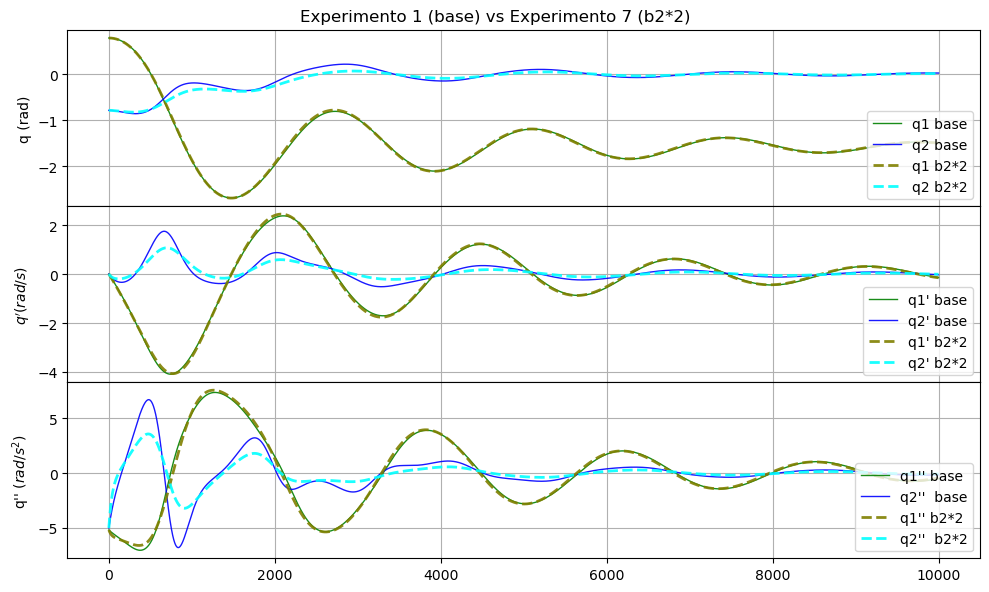

In [24]:
Comparar(7)

#### Duplicate gravity

**ros2 bag record --all -o lab2bag8 -s mcap # lab28bag: base salvo g=19**

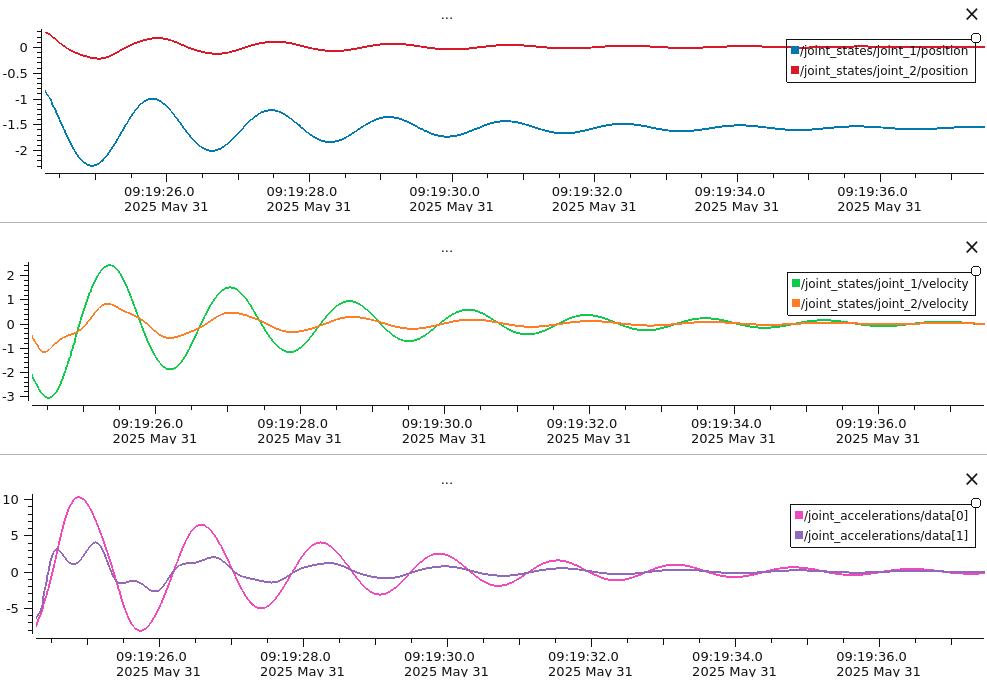


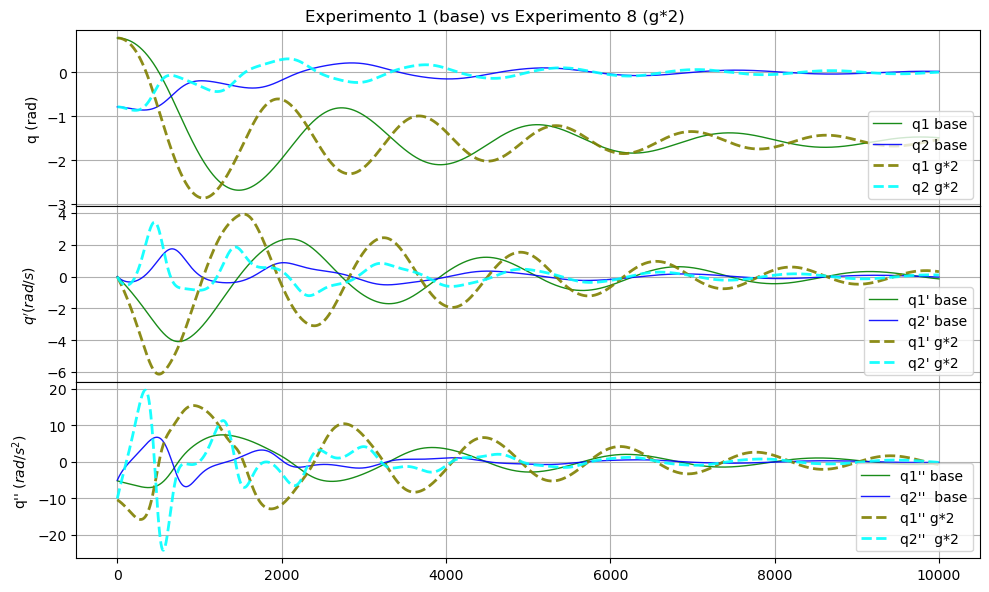

In [25]:
Comparar(8)

## Setup ROS 2 Humble

1. Install the (uma_environment)[https://github.com/jmgandarias/uma_environment_tools]

```bash
wsl --install Ubuntu-22.04

cd
sudo apt update
sudo apt upgrade
git clone https://github.com/jmgandarias/uma_environment_tools.git
cd uma_environment_tools/scripts
./install_uma_environment.sh

update_uma_environment
```

2. Folder structure

```
│
├── uma_environment_tools
│       ├── config
│       ├── README.md
│       └── scripts
├── ros
│    ├── my_first_ros2_ws
|    │   ├── build
|    │   ├── install
|    │   ├── log
|    │   └── src
|    |
│    ├── my_second_ros2_ws
|    │   ├── build
|    │   ├── install
|    │   ├── log
|    │   └── src
|    |
│    └── ...
|       
├── log
│   ├── my_logged_data__YYYY_MM_DD__HH_MM_SS.mat
│   └── ...
│
└── .uma_params.env
```

## Install UMA manipulator package

```bash
cdw
cd src
git clone https://github.com/jmgandarias/uma_arm_description.git

sudo apt install ros-${ROS_DISTRO}-xacro
sudo apt install ros-${ROS_DISTRO}-gazebo-ros-pkgs
sudo  apt install ros-${ROS_DISTRO}-ros2-control ros-${ROS_DISTRO}-ros2-controllers ros-${ROS_DISTRO}-gazebo-ros2-control
sudo apt-get install -y ros-${ROS_DISTRO}-joint-state-publisher-gui ros-${ROS_DISTRO}-rviz2

sudo apt update
sudo apt upgrade

cdw
cb

# run RViz2
ros2 launch uma_arm_description uma_arm_visualization.launch.py

# run UI to move robot joints
ros2 run joint_state_publisher_gui joint_state_publisher_gui
```

## Simulate the robot dynamics

### Clone the uma_arm_control package

```
cdw
cd src
git clone https://github.com/jmgandarias/uma_arm_control.git

cdw
cb
```

### calculate_acceleration

```C++
// Method to calculate joint acceleration
    Eigen::VectorXd calculate_acceleration()
    {

        // Initialize M, C, Fb, g_vec, J, and tau_ext
        Eigen::MatrixXd M(2, 2);    // Inertia matrix
        Eigen::VectorXd C(2);       // Coriolis and centrifugal forces matrix
        Eigen::MatrixXd Fb(2, 2);   // Viscous friction matrix
        Eigen::VectorXd g_vec(2);   // gravity vector
        Eigen::MatrixXd J(2, 2);    //! jacobiano -> preguntar de donde sale
        Eigen::VectorXd tau_ext(2); // joint torques due to external forces

        // Initialize q1, q2, q_dot1, and q_dot2
        double q1 = joint_positions_(0);
        double q2 = joint_positions_(1);
        double q_dot1 = joint_velocities_(0);
        double q_dot2 = joint_velocities_(1);


        // Calculate matrix M
        M(0, 0) = m1_ * pow(l1_, 2) + m2_ * (pow(l1_, 2) + 2 * l1_ * l2_ * cos(q2) + pow(l2_, 2));
        M(0, 1) = m2_ * (l1_ * l2_ * cos(q2) + pow(l2_, 2));
        M(1, 0) = M(0, 1);
        M(1, 1) = m2_ * pow(l2_, 2);

        // Calculate vector C (C is 2x1 because it already includes q_dot)
        C << -m2_ * l1_ * l2_ * sin(q2) * (2 * q_dot1 * q_dot2 + pow(q_dot2, 2)),
              m2_ * l1_ * l2_ * pow(q_dot1, 2) * sin(q2);

        // Calculate Fb matrix
        Fb << b1_, 0.0,
              0.0, b2_;

        // Calculate g_vect
        g_vec << (m1_ + m2_) * l1_ * g_ * cos(q1) + m2_ * g_ * l2_ * cos(q1 + q2),
                    m2_      * l2_ * g_ * cos(q1 + q2);

        // Calculate J
        J << -l1_ * sin(q1) - l2_ * sin(q1 + q2), -l2_ * sin(q1 + q2),
              l1_ * cos(q1) + l2_ * cos(q1 + q2),  l2_ * cos(q1 + q2);

        // Calculate tau_ext
        tau_ext << J.transpose() * external_wrenches_;

        // Calculate joint accelerations using the dynamic model: q'' = M^(-1)[tau - C(q,q')q' - Fbq' - g(q) + tau_ext]
        Eigen::VectorXd q_ddot(2);
        q_ddot << M.inverse() * (joint_torques_ - C - Fb * joint_velocities_ - g_vec + tau_ext);
        
        // Return joint accelerations
        return q_ddot; // joint_accelerations_ = calculate_acceleration()
    }
```


### calculate_velocity (integrate acceleration)

```C++
    // Method to calculate joint velocity
    Eigen::VectorXd calculate_velocity()
    {
        // Integrate velocity over the time step (elapsed_time_)
        Eigen::VectorXd q_dot = joint_velocities_ + joint_accelerations_ * elapsed_time_;
        return q_dot; // joint_velocities_ = calculate_velocity();
    }
```

### calculate_position (integrate velocity)

```C++
    // Method to calculate joint position
    Eigen::VectorXd calculate_position()
    {
        // Integrate position over the time step (elapsed_time_)
        Eigen::VectorXd q = joint_positions_ + joint_velocities_ * elapsed_time_;
        return q; // joint_positions_ = calculate_position();
    }
```

## Launch the dynamics simulator node

```bash

cdw
cb
# run RViz2
ros2 launch uma_arm_description uma_arm_visualization.launch.py

# run simulation of behavior of robot
ros2 launch uma_arm_control uma_arm_dynamics_launch.py

# interaction between topics
rqt_graph

```

## Graphical representation

```bash

# Install plotjuggler
sudo apt update
#sudo apt install plotjuggler
sudo snap install plotjuggler-ros
sudo snap install plotjuggler
# Install mcap storage plugin !
cdw
mkdir experiments
sudo apt-get install ros-humble-rosbag2-storage-mcap

# record experiment
cdw
cd experiments
ros2 bag record --all -o lab2bag1 -s mcap # lab21bag: base => m1=3, m2=2, l1=1, l2=0.6, b1=5, b2=5, g=9.81


# launch experiment
ros2 launch uma_arm_description uma_arm_visualization.launch.py
ros2 launch uma_arm_control uma_arm_dynamics_launch.py

# launch plotjuggler

ros2 bag record -s mcap -a # Records all topics in MCAP format
# or
ros2 bag record -s mcap -o my_mcap_bag /my_topic_1 /my_topic_2


source /opt/ros/${ROS_DISTRO}/setup.bash
source ~/ros/advanced_robotics_ws/install/setup.bash
plotjuggler-ros
```